# Protein Structure Prediction with GNNs

**Alex Allahar Davin Himel**

**STAT-421**

In [48]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # for 3D plotting
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import InMemoryDataset, Data, DataLoader
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool
from Bio.PDB import PDBParser

In [6]:
# --- Graph Neural Network for Protein Structure Prediction ---
class ProteinDataset(Dataset):
    def __init__(self, pdb_files, cutoff=8.0):
        """
        pdb_files: list of paths to .pdb files
        cutoff: distance threshold (Å) for connecting edges
        """
        self.pdb_files = pdb_files
        self.cutoff   = cutoff
        self.parser   = PDBParser(QUIET=True)

    def __len__(self):
        return len(self.pdb_files)

    def __getitem__(self, idx):
        pdb_path = self.pdb_files[idx]
        # parse structure
        struct = self.parser.get_structure(str(idx), pdb_path)
        coords = []
        for model in struct:
            for chain in model:
                for res in chain:
                    if 'CA' in res:
                        coords.append(res['CA'].get_coord())
        coords = np.stack(coords)                     # (N, 3) array
        x = torch.tensor(coords, dtype=torch.float)   # node features

        # build edges by cutoff
        N = x.size(0)
        edge_list = []
        for i in range(N):
            for j in range(i+1, N):
                if torch.norm(x[i] - x[j]) <= self.cutoff:
                    edge_list += [[i, j], [j, i]]
        edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()

        return Data(x=x, edge_index=edge_index)


In [7]:
# --- Example usage for 1a3n.pdb ---
pdb_files = ["data/1a3n.pdb"]  # adjust path as needed
dataset   = ProteinDataset(pdb_files, cutoff=8.0)
loader    = DataLoader(dataset, batch_size=1, shuffle=True)

# Quick EDA: print nodes/edges for each graph
for i, graph in enumerate(dataset):
    print(f"Graph {i}:  nodes = {graph.num_nodes}, edges = {graph.num_edges}")

# Peek at a batched graph
batch = next(iter(loader))
print(batch)

/opt/anaconda3/envs/gnn-protein/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Graph 0:  nodes = 572, edges = 5656
DataBatch(x=[572, 3], edge_index=[2, 5656], batch=[572], ptr=[2])


In [14]:
pdb_path = 'data/1a3n.pdb' 

# Parse C-alpha coordinates
coords = []
with open(pdb_path, 'r') as f:
    for line in f:
        if line.startswith('ATOM') and line[12:16].strip() == 'CA':
            x = float(line[30:38])
            y = float(line[38:46])
            z = float(line[46:54])
            coords.append([x, y, z])

coords = np.array(coords)  # shape (N, 3)
N = coords.shape[0]

In [20]:
# Build adjacency by cutoff (8.0 Å)
if N > 1:
    # pairwise distance matrix
    dists = np.linalg.norm(coords[:, None, :] - coords[None, :, :], axis=-1)
    # count edges for i < j, then bidirectional
    i, j = np.where((dists <= 8.0) & (np.arange(N)[:, None] < np.arange(N)[None, :]))
    edges = len(i) * 2
else:
    edges = 0

# Prepare stats
df_stats = pd.DataFrame([{
    'pdb_file':  pdb_path,
    'num_nodes': N,
    'num_edges': edges
}])

In [21]:
# Print summary
print(df_stats.to_string(index=False))

     pdb_file  num_nodes  num_edges
data/1a3n.pdb        572       5656


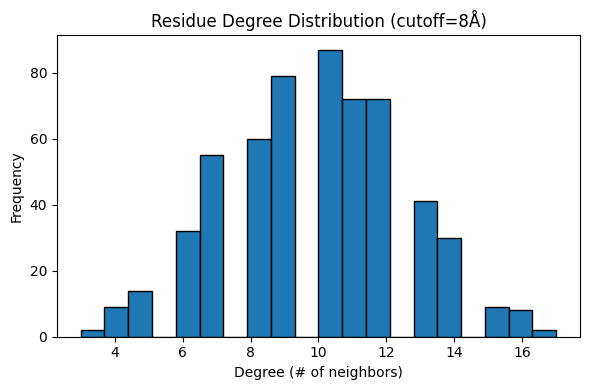

In [22]:
degrees = (dists <= 8.0).sum(axis=1) - 1  

plt.figure(figsize=(6,4))
plt.hist(degrees, bins=20, edgecolor='k')
plt.title('Residue Degree Distribution (cutoff=8Å)')
plt.xlabel('Degree (# of neighbors)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

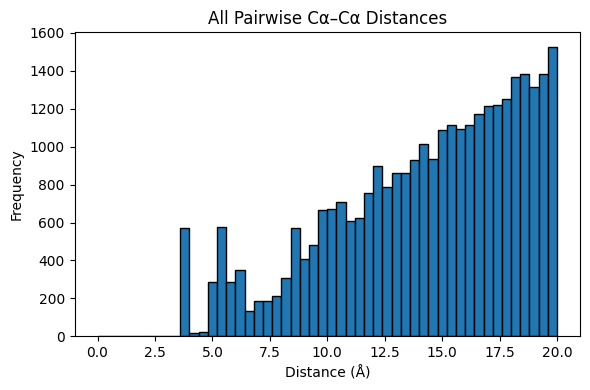

In [23]:
dists_all = dists[np.triu_indices(N, k=1)]  # upper triangle, i<j

plt.figure(figsize=(6,4))
plt.hist(dists_all, bins=50, range=(0,20), edgecolor='k')
plt.title('All Pairwise Cα–Cα Distances')
plt.xlabel('Distance (Å)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

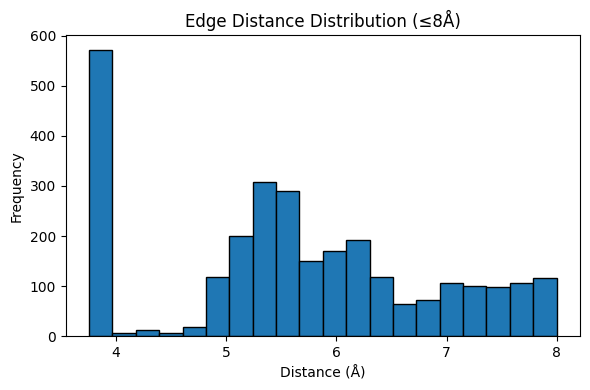

In [24]:
# Edge‐distance distribution (only those ≤8Å)
dists_edges = dists_all[dists_all <= 8.0]

plt.figure(figsize=(6,4))
plt.hist(dists_edges, bins=20, edgecolor='k')
plt.title('Edge Distance Distribution (≤8Å)')
plt.xlabel('Distance (Å)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [25]:
# Summary statistics
print(f"Residue count: {N}")
print(f"Mean degree:    {degrees.mean():.2f}")
print(f"Median degree:  {np.median(degrees):.0f}")
print(f"Max degree:     {degrees.max()}")
print(f"Mean edge dist: {dists_edges.mean():.2f} Å")
print(f"Median edge dist: {np.median(dists_edges):.2f} Å")

Residue count: 572
Mean degree:    9.89
Median degree:  10
Max degree:     17
Mean edge dist: 5.64 Å
Median edge dist: 5.55 Å


In [38]:
# --- Define the GNN model ---
class ProteinGNN(torch.nn.Module):
    def __init__(self, in_channels=3, hidden_channels=64, out_channels=3):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=4, concat=True)
        self.conv2 = GATConv(hidden_channels*4, hidden_channels, heads=1, concat=True)
        self.lin   = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        return self.lin(x)  # [N,3]

In [39]:
# --- Dataset: y = true distance map --- 
class SingleProteinDataset(torch.utils.data.Dataset):
    def __init__(self, pdb_file, cutoff=8.0):
        self.pdb_file = pdb_file
        self.cutoff   = cutoff

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        # parse Cα coords
        coords = []
        with open(self.pdb_file, 'r') as f:
            for line in f:
                if line.startswith('ATOM') and line[12:16].strip()=='CA':
                    coords.append(list(map(float, [line[30:38], line[38:46], line[46:54]])))
        coords = torch.tensor(np.stack(coords), dtype=torch.float)  # [N,3]
        # true distance map
        dist_map = torch.cdist(coords, coords)                    # [N,N]
        # edges for the graph
        mask      = dist_map <= self.cutoff
        edge_index = mask.nonzero(as_tuple=False).t()              # [2,E]
        # Return graph with labels in .y
        return Data(x=coords, edge_index=edge_index, y=dist_map)


In [40]:
# --- Prepare data & model --- 
dataset = SingleProteinDataset('data/1a3n.pdb')
loader  = DataLoader(dataset, batch_size=1, shuffle=False)
model     = ProteinGNN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()

In [41]:
# --- Train with distance-map loss --- 
for epoch in range(1, 11):
    total_loss = 0.0
    model.train()
    for batch in loader:
        optimizer.zero_grad()
        # 4a) predict coords
        pred_coords = model(batch.x, batch.edge_index)       # [N,3]
        # 4b) build predicted distance map
        pred_dist   = torch.cdist(pred_coords, pred_coords)  # [N,N]
        # 4c) compare with true dist_map in batch.y
        loss = criterion(pred_dist, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch:02d} — DistMap Loss: {total_loss:.4f}")

Epoch 01 — DistMap Loss: 1007.0414
Epoch 02 — DistMap Loss: 970.6365
Epoch 03 — DistMap Loss: 933.4545
Epoch 04 — DistMap Loss: 895.5763
Epoch 05 — DistMap Loss: 856.9172
Epoch 06 — DistMap Loss: 817.7155
Epoch 07 — DistMap Loss: 778.1495
Epoch 08 — DistMap Loss: 738.3015
Epoch 09 — DistMap Loss: 698.3500
Epoch 10 — DistMap Loss: 658.6369


In [44]:
def rmsd(pred, true):
    """Root Mean Square Deviation between two [N,3] arrays."""
    return np.sqrt(np.mean((pred - true)**2))

def gdt_ts(pred, true, cutoffs=(1,2,4,8)):
    """
    Global Distance Test (total score) approximation.
    For each cutoff, fraction of Cα within that distance, then average.
    """
    # per-residue distances
    dists = np.linalg.norm(pred - true, axis=1)  # shape (N,)
    scores = [(dists <= c).mean() for c in cutoffs]
    return 100 * np.mean(scores)

In [45]:
# 2) Run one evaluation pass on your single‐protein loader
model.eval()
with torch.no_grad():
    for batch in loader:
        # predict coords
        pred_coords = model(batch.x, batch.edge_index)       # Tensor [N,3]
        true_coords = batch.x                                # Tensor [N,3]
        
        # move to NumPy
        pred_np = pred_coords.cpu().numpy()
        true_np = true_coords.cpu().numpy()
        
        # compute metrics
        val_rmsd  = rmsd(pred_np, true_np)
        val_gdt   = gdt_ts(pred_np, true_np)
        
        print(f"RMSD: {val_rmsd:.4f} Å")
        print(f"GDT-TS: {val_gdt:.2f} %")

RMSD: 22.0298 Å
GDT-TS: 0.57 %


In [46]:
pred_dist = torch.cdist(pred_coords, pred_coords)  # [N,N]
dist_loss = torch.nn.functional.mse_loss(pred_dist, batch.y)
print("Distance‐map MSE:", dist_loss.item())

Distance‐map MSE: 618.9960327148438


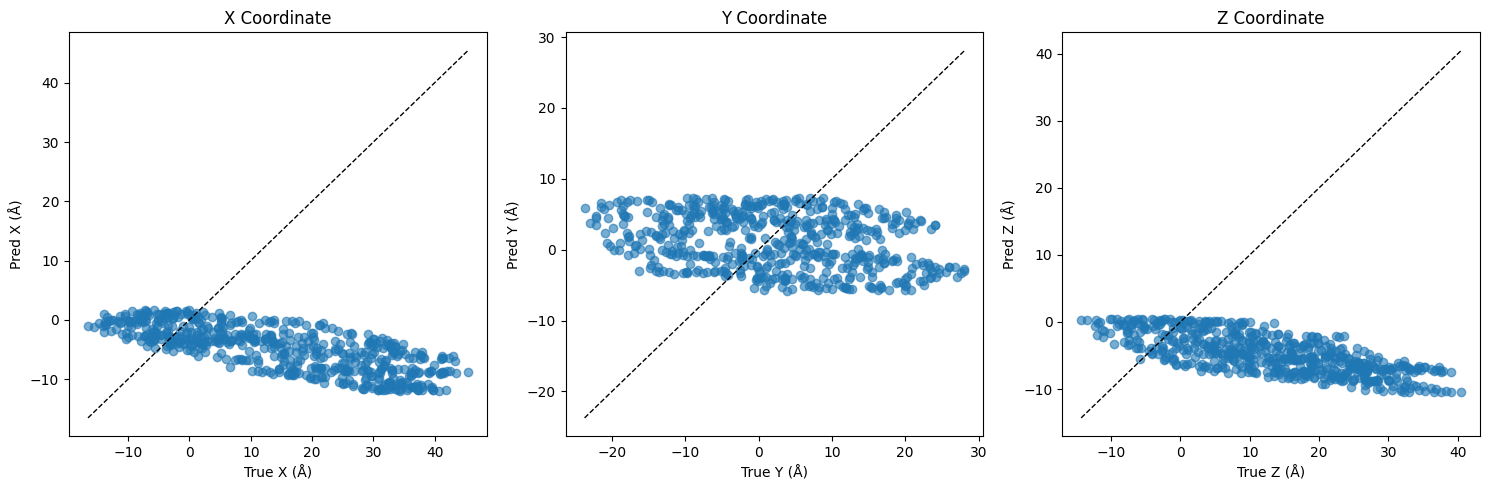

In [47]:
# --- 1) 2D Scatter: true vs predicted for each axis ---
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axes = ['X','Y','Z']
for i, ax in enumerate(axs):
    ax.scatter(true_np[:, i], pred_np[:, i], alpha=0.6)
    mn = min(true_np[:, i].min(), pred_np[:, i].min())
    mx = max(true_np[:, i].max(), pred_np[:, i].max())
    ax.plot([mn, mx], [mn, mx], 'k--', lw=1)  # identity line
    ax.set_xlabel(f'True {axes[i]} (Å)')
    ax.set_ylabel(f'Pred {axes[i]} (Å)')
    ax.set_title(f'{axes[i]} Coordinate')
plt.tight_layout()
plt.show()

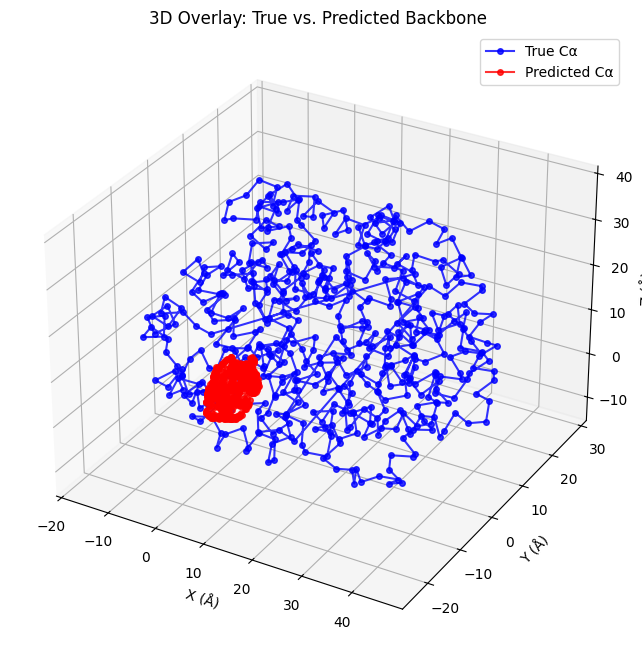

In [49]:
# --- 2) 3D Overlay: backbone trace of true vs predicted ---
fig = plt.figure(figsize=(8, 8))
ax3 = fig.add_subplot(111, projection='3d')

# True backbone
ax3.plot(true_np[:, 0], true_np[:, 1], true_np[:, 2],
         '-o', color='blue', label='True Cα', markersize=4, alpha=0.8)

# Predicted backbone
ax3.plot(pred_np[:, 0], pred_np[:, 1], pred_np[:, 2],
         '-o', color='red',  label='Predicted Cα', markersize=4, alpha=0.8)

ax3.set_xlabel('X (Å)')
ax3.set_ylabel('Y (Å)')
ax3.set_zlabel('Z (Å)')
ax3.set_title('3D Overlay: True vs. Predicted Backbone')
ax3.legend()
plt.show()